In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/MyDrive/Judging under influence/datasets"

Mounted at /content/drive
FinalDatasetFullJudgements_NOFRENCH.csv  newFullJudgDataset.csv
FinalDatasetParagraphs.csv


In [ ]:
!pip install git+https://github.com/tensorflow/docs
    
import io
import random
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold 

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout,GlobalMaxPooling1D, Conv1D, Flatten, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import datetime

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-461pmiog
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-461pmiog
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180247 sha256=f93a2cf85b100321aef2c5505724eeabac88ba972e52e137e113950efc644e2a
  Stored in directory: /tmp/pip-ephem-wheel-cache-r2hwjlp4/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Num GPUs Available:  1


In [ ]:
#Keras do not implement F1 so I implemented "myself"
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#-----input and creating of tensors dataset
data = pd.read_csv("/content/drive/MyDrive/Judging under influence/datasets/FinalDatasetParagraphs.csv",index_col = 0,low_memory=False,encoding = "ISO-8859-1") #not utf-8 encoded
df=data.filter(["DEF","TEXT"], axis=1)
df=df.dropna() #non applicable deleted atm
df["DEF"]=df["DEF"].astype(int)
df.reset_index(drop=True, inplace=True) 



In [ ]:
def remove_punctuation_numbers(input_text):
    '''
    Function to remove English stopwords and preprocess text from a Pandas Series using NLTK and REGEX.
    
    Parameters:
        input_text : text to clean as pandas series
    Output:
        cleaned Pandas Series 
    '''
    
    
    #select only the text, no puctuation
    tokenizer = RegexpTokenizer(r'\w+')
    #remove numbers
    text_nonum = re.sub(r'\d+', '', input_text)
    
    words = tokenizer.tokenize(text_nonum.lower())
    #words = input_text.lower().split() 
    #remove stopwords
    #clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    clean_data = " ".join(words)



    lowercase = clean_data.lower()
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '').numpy()

#remove the stopeords now
df['CLEAN_TEXT'] = df.TEXT.apply(remove_punctuation_numbers)


target = df.pop('DEF')
dataset = tf.data.Dataset.from_tensor_slices((df.CLEAN_TEXT.values, target.values))


In [ ]:
#Here i get the split from the dataset, the split is 80 % for the k-fold and 20% for an independent test set.
#The test set is used to asses the performance on unseen data on the best cv values

#this is used for testing purposes, generates a dataset of nums from 0 to 19
#dataset = tf.data.Dataset.range(20)

DATASET_SIZE = dataset.cardinality().numpy()
SPLITS = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 512 #very important! Reducing this in RNN let them run on slower pc at the cost of exec time (increasing does the opposite)
TEST_SIZE = 0.15


def get_dataset_partitions(ds = dataset, ds_size= DATASET_SIZE, n_splits = SPLITS, test_size=TEST_SIZE, shuffle=True, shuffle_size=DATASET_SIZE, BATCH_SIZE = BATCH_SIZE):
    fold_size = 1/n_splits
    split_size = ds_size * (1-test_size) * fold_size
    CV_folds = []
    
    if shuffle:
        # Specify seed=xx to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, reshuffle_each_iteration=False, seed=5)#poi 1996
    
    test_dataset = ds.skip(ds_size * (1-test_size))
    cv_dataset = ds.take(ds_size * (1-test_size))
    
    #print(list(test_dataset.as_numpy_iterator()))
    #print(list(cv_dataset.as_numpy_iterator()))
    
    #print(list(test_dataset.as_numpy_iterator()))
    #print(list(cv_dataset.as_numpy_iterator()))
    
    for i in range(n_splits):         #dataset is divided in 3 pieces for each iteration, train1 | validation | train2 due to take/skip nature
        
        #we will concatenate train1 and train2 to define the fitting split for the current fold while val will be the validation
        
        train1 = cv_dataset.take(i * split_size) #each of the 2 train(1 and 2) can be of size [0,fold_size*num_splits-1], val have dimension= fold_size
        val = cv_dataset.skip(i * split_size).take(split_size)
        train2 = cv_dataset.skip(i * split_size).skip(split_size)
    
      
        #print(list(train1.concatenate(train2).as_numpy_iterator()))
        #print(list(val.as_numpy_iterator()))

        #we generate a list of tuples. Each tuple contain the train/validation for each fold. The list is indeed SPLITS-long.
        CV_folds.append([
                         train1.concatenate(train2).shuffle(train1.concatenate(train2).cardinality().numpy()).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE),
                         val.shuffle(val.cardinality().numpy()).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
                        ])
        
        #print("CV:")
        #print(list(CV_folds[i][0].as_numpy_iterator()))
        ##print(list(CV_folds[i][1].as_numpy_iterator()))
        #print("--------------------------------------")
    
    
    return [CV_folds,
            test_dataset.shuffle(test_dataset.cardinality().numpy()).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE),
            cv_dataset.shuffle(cv_dataset.cardinality().numpy()).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)]
    


CV_folds, test_dataset, train_ds_final = get_dataset_partitions()

#print(list(test_dataset.as_numpy_iterator()))
#print(list(train_ds_final.as_numpy_iterator()))

In [ ]:
#----- Class Imabalance dealing
labels=[]
labels=np.array(labels)
for example, label in dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).take(-1):
    _ = example.numpy()
    labels=np.concatenate((labels,label.numpy()))
    
#print(len(labels))
nonzero = np.count_nonzero(labels)
print("Number of 1 : "+str(nonzero))
print("Number of 0 : "+str(len(labels)-nonzero))
#positive/total ratio:
posWeight = len(labels)/nonzero
print("Weight of positive elements: "+str(posWeight))

Number of 1 : 18089
Number of 0 : 67783
Weight of positive elements: 4.747194427552657


In [ ]:
#define the metrics I want to see during the iterations
METRICS = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      f1, #my f1
      tf.keras.metrics.AUC(name='auc'),
    
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      
      
]

In [ ]:
def get_callbacks():
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(patience = 10, monitor = 'val_f1',  mode = 'max', min_delta = 0.01),#ma need an increase?
    #tf.keras.callbacks.TensorBoard('logsGraphs/graphsFolder'),
  ]


  

## Define CV e Tensoboard params

In [ ]:
#loading of tensorboard and deleting of old logs(windows10 only I guess)
%reload_ext tensorboard
#shutil.rmtree("./logsGraphs", ignore_errors=True, onerror=None)

In [ ]:
#here I defined the parameters i want to iterate through

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64,128]))
HP_EMBEDDING_DIM = hp.HParam('emb_dim', hp.Discrete([64,128]))
HP_OPTIMIZER_LR = hp.HParam('opt_lr', hp.Discrete([ 0.001, 0.0005, 0.0001, 0.00005, 0.00001]))
HP_WEIGHT_TUNER = hp.HParam('pos_weight_tuner', hp.RealInterval(1.0,3.0))#selected later
HP_NUM_LAYERS = hp.HParam('num_layers', hp.Discrete([2,3]))#always add +1 per final layer
HP_NUM_EPOCHS = hp.HParam('num_epochs', hp.Discrete([40]))
#HP_KERNEL_REGULARIZATION_L2 = hp.HParam('ker_l2', hp.Discrete([1e-25, 1e-4, 1e-5, 1e-6, 1e-7]))
#HP_KERNEL_REGULARIZATION_L1 = hp.HParam('ker_l1', hp.Discrete([1e-25, 1e-4, 1e-5, 1e-6, 1e-7]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.2, 0.25, 0.3]))


#here we choose the metrics we want to average after CV, we only choose the most important ones to do not loose the focus
METRIC1 = 'f1'
METRIC2 = 'auc'#attention! If we have 0 precision/recall we might have errors due to AUC implmentation, MAY BE REMOVED

with tf.summary.create_file_writer('logsGraphs/hparam_tuningCV').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_EMBEDDING_DIM, HP_OPTIMIZER_LR, HP_WEIGHT_TUNER, HP_NUM_LAYERS, HP_NUM_EPOCHS, HP_DROPOUT],
    metrics=[hp.Metric(METRIC1, display_name='f1'),hp.Metric(METRIC2, display_name='auc')],
  )



## Define the CV model

In [ ]:
#this is the function that creates the ANN given the parameters.
#after creating it the ANN is fitted on the current split's train set and vchecked on the current validation set
#we return the f1 and auc of the current validation split as the measure of performance of this split
#the f1 and auc over all the splits will be later averaged and will be the parameters performance

VOCAB_SIZE = 30000#define size of vocabulary, as it says

def train_test_model(emb_dim, num_units, learning_rate, weight_normalizer, num_layers, train_dataset, val_dataset, num_epochs, dropout):
  
  encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
  encoder.adapt(train_dataset.map(lambda text, label: text))

#---------------------------------------------------------------------
  model = Sequential([
      
  encoder,
    
  Embedding(#embedding layer
        input_dim=len(encoder.get_vocabulary()),
        output_dim=emb_dim,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    
  #Bidirectional(tf.keras.layers.LSTM(emb_dim , dropout = 0.1,return_sequences=True)),
  
  Bidirectional(tf.keras.layers.LSTM(emb_dim)),    
  #Dropout(dropout)

  ])
    
  for i in range(num_layers):
    if num_units/pow(2,i) >1 :
        model.add(Dense(num_units/pow(2,i), activation="relu"))
        #model.add(Dropout(dropout))
            
  model.add(Dense(1,activation='sigmoid')) 


  class_weight = {0: 1., #class 0 weight
                  1: posWeight/weight_normalizer, #uses the weight I set to make them perfectly balanced, I can increase it to overweight pos class!
                                     
                  2: 2.} 
    

  
  model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=METRICS)
   

  history = model.fit(
             train_dataset,
             epochs=num_epochs,
             class_weight=class_weight,
             validation_data = val_dataset,
             callbacks=get_callbacks()
             ) 

  _, prec, recall, f1,auc, tp, tn, fp, fn, accuracy = model.evaluate(val_dataset)#validation we get our performances from this performance assesment
  del model
  del train_dataset
  del val_dataset
  return f1,auc, history#take only the most important measures to retain the focus

In [ ]:
#this method runs the cross validation, calling the above method giving it the parameters choosen and recording performances 
#it computes the average of f1 and auc over the various splits as well

def run(run_dir, hparams, session_num):
  with tf.summary.create_file_writer(run_dir).as_default():
    # record the values used in this trial
    hp.hparams(hparams)
    f1Score,auc = 0,0
    history={}
    
    for i in range(SPLITS):#averaging over all the splits
      print("\nCHECKING SPLIT NUM: "+str(i+1))
      train_dataset,val_dataset = CV_folds[i]
      tmpf1,tmpauc,history["split "+str(i+1)] =  train_test_model(emb_dim = hparams[HP_EMBEDDING_DIM],
                                                  num_units = hparams[HP_EMBEDDING_DIM],#num_units = embedding best practice
                                                  learning_rate = hparams[HP_OPTIMIZER_LR],
                                                  weight_normalizer= hparams[HP_WEIGHT_TUNER],
                                                  num_layers = hparams[HP_NUM_LAYERS],
                                                  num_epochs = hparams[HP_NUM_EPOCHS],
                                                  dropout = hparams[HP_DROPOUT],
                                                  train_dataset = train_dataset,
                                                  val_dataset = val_dataset)
      f1Score += tmpf1
      auc += tmpauc
      
    
    f1Score /= SPLITS
    auc /= SPLITS
    
    print("!!! SESSION NUM "+str(session_num)+" ---> CV f1: "+str(f1Score))
    print("!!! auc: "+str(auc)+"\n------------------------------------------")
    
    plotter = tfdocs.plots.HistoryPlotter(metric = 'f1', smoothing_std=10)
    plotter.plot(history)
    plt.show()
    print("\n------------------------------------------")
    
    plotter = tfdocs.plots.HistoryPlotter(metric = 'auc', smoothing_std=10)
    plotter.plot(history)
    plt.show()
    
    tf.summary.scalar(METRIC1, f1Score, step = tf.convert_to_tensor(1, dtype=tf.int64))
    tf.summary.scalar(METRIC2, auc, step = tf.convert_to_tensor(1, dtype=tf.int64))

## Run the tuning model

In [ ]:
params = ['38.027177', '31.500068', '0.009071', '1.182932', '2.662170', '0.029260', '0.000000', '0.000000']

Trying parameters given by user
!--WARNING--! DROPOUT and CLASS_WEIGHT are DISABLED and  EMB_DIM=NUM_UNITS
--- Starting trial: run-1
{'num_units': 31, 'emb_dim': 38, 'opt_lr': 0.009071, 'pos_weight_tuner': 2.66217, 'num_layers': 1, 'num_epochs': 40, 'dropout': 0.02926}

CHECKING SPLIT NUM: 1
Epoch 1/40
107/107 [==============================] - ETA: 0s - loss: 0.6546 - precision: 0.4555 - recall: 0.3063 - f1: 0.3220 - auc: 0.7132 - tp: 3518.0000 - tn: 39051.0000 - fp: 4206.0000 - fn: 7969.0000 - accuracy: 0.7776
Epoch: 0, accuracy:0.7776,  auc:0.7132,  f1:0.3220,  fn:7969.0000,  fp:4206.0000,  loss:0.6546,  precision:0.4555,  recall:0.3063,  tn:39051.0000,  tp:3518.0000,  val_accuracy:0.6439,  val_auc:0.7989,  val_f1:0.4898,  val_fn:765.0000,  val_fp:5733.0000,  val_loss:0.6148,  val_precision:0.3530,  val_recall:0.8035,  val_tn:8621.0000,  val_tp:3128.0000,  
107/107 [==============================] - 28s 130ms/step - loss: 0.6546 - precision: 0.4555 - recall: 0.3063 - f1: 0.3220 - au

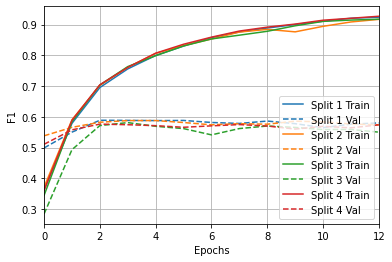


------------------------------------------


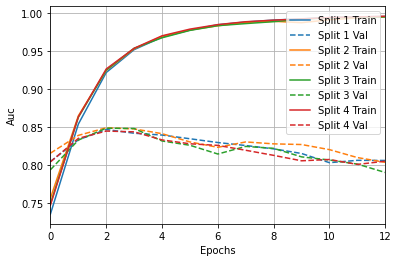

In [ ]:
#this is the highest-level method that runs the 2 above, call many times the run(....) method with different params combination

#you can choose: 1) to iterate one after all the paramters (not working atm, need to be added optimzier and num-epochs params)
#                2) Sample randomly from the paramters we have, useful for having a general idea of the performances

#the HParams framework is taken form the Tensorflow webpage as a "standard" hyperparameter optimization framework

def run_tuning(random_parameters):
    #take the user gin parameters
    if not random_parameters :
        print("Trying parameters given by user")
                 
        session_num = 1
        #this while is here simply because after around 20/25 combinations Colab RAM/my pc RAM is full and i need to restart
        emb_dim = int(float(params[0]))#here parameters are ind fiferent orders!
        num_units = int(float(params[1]))
        opt_lr = float(params[2])
        num_layers = int(float(params[3]))
        weight_tuner = float(params[4])
        dropout = float(params[5])
        num_epochs = 40 

        hparams = {
          HP_NUM_UNITS: num_units, #num un= emb_dim
          HP_EMBEDDING_DIM: emb_dim,
          HP_OPTIMIZER_LR: opt_lr,
          HP_WEIGHT_TUNER: weight_tuner,
          HP_NUM_LAYERS: num_layers,
          HP_NUM_EPOCHS: num_epochs,
          #HP_KERNEL_REGULARIZATION_L2: ker_l2,
          #HP_KERNEL_REGULARIZATION_L1: ker_l1
          HP_DROPOUT: dropout
        }

        run_name = "run-%d" % session_num

        print("!--WARNING--! DROPOUT and CLASS_WEIGHT are DISABLED and  EMB_DIM=NUM_UNITS")

        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})

        #call the run(..) method defined earlier
        run('logsGraphs/hparam_tuningCV/' + run_name, hparams, session_num)


            
              
    if random_parameters :
        print("Trying parameters at random")
                 
        session_num = 0
        #this while is here simply because after around 20/25 combinations Colab RAM/my pc RAM is full and i need to restart
        while session_num <= 50:
            num_units = random.choice(HP_NUM_UNITS.domain.values)
            emb_dim = random.choice(HP_EMBEDDING_DIM.domain.values)
            
            opt_lr = random.choice(HP_OPTIMIZER_LR.domain.values)
            weight_tuner = random.choice([0.3, 0.5, 0.7, 1.1, 1.3, 1.5])
            num_layers = random.choice(HP_NUM_LAYERS.domain.values)
            num_epochs = random.choice(HP_NUM_EPOCHS.domain.values)
            dropout = random.choice(HP_DROPOUT.domain.values)
            
            #creates a dictionary with the random sampled parameters, taken at random every time
            hparams = {
              HP_NUM_UNITS: num_units,
              HP_EMBEDDING_DIM: emb_dim,
              HP_OPTIMIZER_LR: opt_lr,
              HP_WEIGHT_TUNER: weight_tuner,
              HP_NUM_LAYERS: num_layers,
              HP_NUM_EPOCHS: num_epochs,
              HP_DROPOUT: dropout
            }

            run_name = "run-%d" % session_num
            print("!--WARNING--! DROPOUT and CLASS_WEIGHT are DISABLED and  EMB_DIM=NUM_UNITS")
            
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            #call the run(..) method defined earlier
            run('logsGraphs/hparam_tuningCV/' + run_name, hparams, session_num)
            session_num += 1

                
run_tuning(random_parameters=False)

In [ ]:
#%reload_ext tensorboard
#%tensorboard --logdir 'logsGraphs/hparam_tuningCV/' --host localhost --port 9089

## Final Refit on the retained Test_set

In [ ]:
def get_callbacks():
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(patience = 7, monitor = 'val_f1',  mode = 'max', min_delta = 0.05),#ma need an increase?
    #tf.keras.callbacks.TensorBoard('logsGraphs/graphsFolder'),
  ]

In [ ]:
#----- Class Imabalance dealing here
labels=np.array([])
for example, label in test_dataset.take(-1):
    labels=np.concatenate((labels,label.numpy()))
    
nonzero = np.count_nonzero(labels)
print("Test set Number of 1 : "+str(nonzero))
print("Test set Number of 0 : "+str(len(labels)-nonzero))

Test set Number of 1 : 2709
Test set Number of 0 : 10172


In [ ]:
#redefine the encoding on the WHOLE train set (80% of the dataset)
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds_final.map(lambda text, label: text))

In [ ]:
emb_dim = int(float(params[0]))#here parameters are ind fiferent orders!
num_units = int(float(params[1]))
opt_lr = float(params[2])
num_layers = int(float(params[3]))
weight_tuner = float(params[4])
dropout = float(params[5])
num_epochs = 40 

In [ ]:


model = tf.keras.Sequential([
    
    encoder, #input layer
    tf.keras.layers.Embedding( #embedding layer
        input_dim=len(encoder.get_vocabulary()),
        output_dim=emb_dim,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
  
    Bidirectional(tf.keras.layers.LSTM(emb_dim )), 
    
     
    
    
])
  
for i in range(num_layers):
    if num_units/pow(2,i) >1 :
        model.add(Dense(num_units/pow(2,i), activation="relu"))
        #model.add(Dropout(dropout))

model.add(Dense(1,activation='sigmoid')) 

model.compile(
      optimizer=tf.keras.optimizers.Adam(opt_lr),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=METRICS,
  )

class_weight = {0: 1., #class 0 weight
                1: posWeight/weight_tuner, #uses the weight I set to make them perfectly balanced, I can increase it to overweight pos class!
                                 
                2: 2.} 



In [ ]:
#----fitting
history = model.fit(train_ds_final, 
                    epochs = num_epochs, 
                    #validation_steps=20, #uses only a portion of validation set
                    class_weight=class_weight,
                    validation_data=test_dataset,
                    callbacks=get_callbacks())


Epoch 1/40
143/143 [==============================] - ETA: 0s - loss: 0.6386 - precision: 0.5110 - recall: 0.3725 - f1: 0.3312 - auc: 0.7423 - tp: 7163.0000 - tn: 65152.0000 - fp: 6854.0000 - fn: 12069.0000 - accuracy: 0.7926
Epoch: 0, accuracy:0.7926,  auc:0.7423,  f1:0.3312,  fn:12069.0000,  fp:6854.0000,  loss:0.6386,  precision:0.5110,  recall:0.3725,  tn:65152.0000,  tp:7163.0000,  val_accuracy:0.8318,  val_auc:0.8263,  val_f1:0.5112,  val_fn:1579.0000,  val_fp:587.0000,  val_loss:0.3945,  val_precision:0.6581,  val_recall:0.4171,  val_tn:9585.0000,  val_tp:1130.0000,  
143/143 [==============================] - 26s 128ms/step - loss: 0.6386 - precision: 0.5110 - recall: 0.3725 - f1: 0.3312 - auc: 0.7423 - tp: 7163.0000 - tn: 65152.0000 - fp: 6854.0000 - fn: 12069.0000 - accuracy: 0.7926 - val_loss: 0.3945 - val_precision: 0.6581 - val_recall: 0.4171 - val_f1: 0.5112 - val_auc: 0.8263 - val_tp: 1130.0000 - val_tn: 9585.0000 - val_fp: 587.0000 - val_fn: 1579.0000 - val_accuracy: 0.

In [ ]:
history2={}
history2["split "+str(i+1)]=history
history= history2

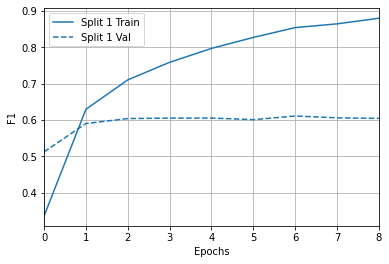

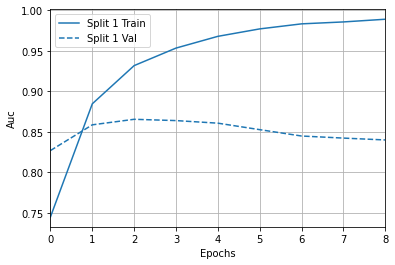

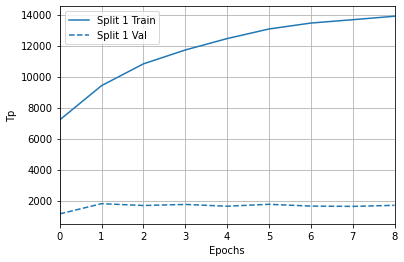

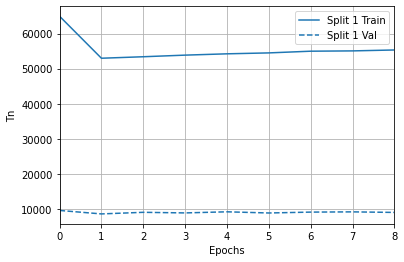

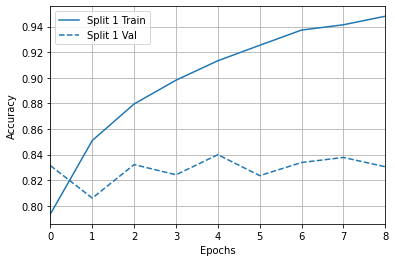

26/26 [==============================] - 1s 41ms/step - loss: 0.6843 - precision: 0.5913 - recall: 0.6264 - f1: 0.6073 - auc: 0.8399 - tp: 1697.0000 - tn: 8999.0000 - fp: 1173.0000 - fn: 1012.0000 - accuracy: 0.8304
Test Accuracy: 0.830370306968689
Test Prec: 0.591289222240448
Test Recall: 0.6264303922653198
Test AUC: 0.8398833870887756
Test F1:  0.6072593927383423
Test Loss: 0.6843438744544983


In [ ]:
#1 solo layer ora
plotter = tfdocs.plots.HistoryPlotter(metric = 'f1', smoothing_std=10)
plotter.plot(history)
plt.show() 

plotter = tfdocs.plots.HistoryPlotter(metric = 'auc', smoothing_std=10)
plotter.plot(history)
plt.show() 

plotter = tfdocs.plots.HistoryPlotter(metric = 'tp', smoothing_std=10)
plotter.plot(history)
plt.show() 

plotter = tfdocs.plots.HistoryPlotter(metric = 'tn', smoothing_std=10)
plotter.plot(history)
plt.show() 

plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(history)
plt.show() 

#get you result on the independent test set to asses performance on unseen data
test_loss,  test_prec, test_rec, test_f1, test_auc,_1,_2,_3,_4,test_acc = model.evaluate(test_dataset)


print('Test Accuracy:', test_acc)
print('Test Prec:', test_prec)
print('Test Recall:', test_rec)
print('Test AUC:', test_auc)
print('Test F1: ',test_f1)
print('Test Loss:', test_loss)

### Save model

In [ ]:
model.save('/content/drive/MyDrive/Judging under influence/FINAL_MODELS_SAVED/DEF/RNN/DEF_RNN_PARAGRAPHS',save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Judging under influence/FINAL_MODELS_SAVED/DEF/RNN/DEF_RNN_PARAGRAPHS/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Judging under influence/FINAL_MODELS_SAVED/DEF/RNN/DEF_RNN_PARAGRAPHS/assets


In [ ]:
#loaded_model.load_weights()
#we set compile=False because of the custom losses that can't be loaded 
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Judging under influence/FINAL_MODELS_SAVED/DEF/RNN/DEF_RNN_PARAGRAPHS',compile=False)
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, None, 38)          1140000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 76)               23408     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 31)                2387      
                                                                 
 dense_9 (Dense)             (None, 1)                 32        
                                                                 
Total params: 1,165,827
Trainable params: 1,165,827
No

In [ ]:
new_model.compile(
          optimizer=tf.keras.optimizers.Adam(opt_lr),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=METRICS,
      )



In [ ]:

#get you result on the independent test set to asses performance on unseen data
test_loss,  test_prec, test_rec, test_f1, test_auc,_1,_2,_3,_4,test_acc = new_model.evaluate(test_dataset)


print('Test Accuracy:', test_acc)
print('Test Prec:', test_prec)
print('Test Recall:', test_rec)
print('Test AUC:', test_auc)
print('Test F1: ',test_f1)
print('Test Loss:', test_loss)

26/26 [==============================] - 6s 42ms/step - loss: 0.6843 - precision: 0.5913 - recall: 0.6264 - f1: 0.6070 - auc: 0.8399 - tp: 3394.0000 - tn: 17998.0000 - fp: 2346.0000 - fn: 2024.0000 - accuracy: 0.8304
Test Accuracy: 0.830370306968689
Test Prec: 0.591289222240448
Test Recall: 0.6264303922653198
Test AUC: 0.8398833870887756
Test F1:  0.6069505214691162
Test Loss: 0.6843438744544983


## Dummy predictor

In [ ]:
from sklearn.metrics import recall_score,precision_score,roc_curve,roc_auc_score,f1_score,accuracy_score

test_labels=[]
test_labels=np.array(test_labels)
for example, label in test_dataset.take(-1):
    _ = example.numpy()
    test_labels=np.concatenate((test_labels,label.numpy()))
    
#print(test_labels)

#Results using dummy classification on the test set
accuracy = accuracy_score(test_labels,np.zeros(len(test_labels)))#predict all zeroes
precision = precision_score(test_labels,np.zeros(len(test_labels)))
recall = recall_score(test_labels,np.zeros(len(test_labels)))
auc = roc_auc_score(test_labels,np.zeros(len(test_labels)))
f1 = f1_score(test_labels,np.zeros(len(test_labels)))



print("Precision : "+str(precision))
print("Recall : "+str(recall))
print("AUC : "+str(auc))
print("F1 : "+str(f1))
print("accuracy: "+str(accuracy))

Precision : 0.0
Recall : 0.0
AUC : 0.5
F1 : 0.0
accuracy: 0.789690241440882


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
